Dataset : https://www.kaggle.com/datasets/vivekvivek13/weather-forecasting

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback
from keras.layers import Dense, LSTM, Bidirectional, Dropout

In [ ]:
# Load the weather dataset
data_train = pd.read_csv('weather.csv')
data_train.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [ ]:
# Display the shape and information of the dataset
data_train.shape
data_train.info()

# Check null and non-null values in the '_tempm' column
null_count = data_train[' _tempm'].isnull().sum()
non_null_count = data_train[' _tempm'].count()

print()
print(f'Number of null values in _tempm: {null_count}')
print(f'Number of non-null values in _tempm: {non_null_count}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime_utc  98913 non-null  object 
 1    _conds       98845 non-null  object 
 2    _dewptm      98294 non-null  float64
 3    _fog         98913 non-null  int64  
 4    _hail        98913 non-null  int64  
 5    _heatindexm  29111 non-null  float64
 6    _hum         98160 non-null  float64
 7    _precipm     0 non-null      float64
 8    _pressurem   98682 non-null  float64
 9    _rain        98913 non-null  int64  
 10   _snow        98913 non-null  int64  
 11   _tempm       98244 non-null  float64
 12   _thunder     98913 non-null  int64  
 13   _tornado     98913 non-null  int64  
 14   _vism        94497 non-null  float64
 15   _wdird       84533 non-null  float64
 16   _wdire       84533 non-null  object 
 17   _wgustm      1063 non-null   float64
 18   _windchillm  573 non-null

In [ ]:
# Convert the 'datetime_utc' column to datetime format
data_train['datetime_utc'] = pd.to_datetime(data_train['datetime_utc'])

# Fill missing values in the '_tempm' column with the mean value
data_train[' _tempm'].fillna(data_train[' _tempm'].mean(), inplace=True)
data_train = data_train[['datetime_utc', ' _tempm']]

# Check null and non-null values in the '_tempm' column
null_count = data_train[' _tempm'].isnull().sum()
non_null_count = data_train[' _tempm'].count()

print(f'Number of null values in _tempm: {null_count}')
print(f'Number of non-null values in _tempm: {non_null_count}')

Number of null values in _tempm: 0
Number of non-null values in _tempm: 98913


In [ ]:
data_train

,datetime_utc,_tempm
0,1996-11-01 11:00:00,30.0
1,1996-11-01 12:00:00,28.0
2,1996-11-01 13:00:00,24.0
3,1996-11-01 14:00:00,24.0
4,1996-11-01 16:00:00,23.0
...,...,...
98908,2016-11-30 12:30:00,21.0
98909,2016-11-30 13:00:00,19.0
98910,2016-11-30 15:00:00,17.0
98911,2016-11-30 18:00:00,15.0


Text(0.5, 1.0, 'Temperature average')

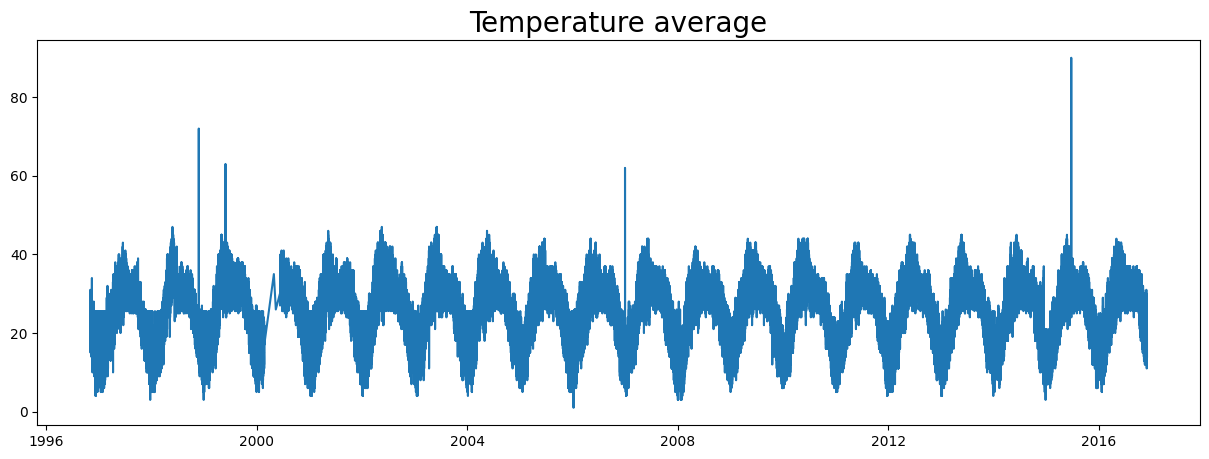

In [ ]:
# Extract features and target variable
date = data_train['datetime_utc'].values
temp = data_train[' _tempm'].values

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(temp, date, test_size=0.2, random_state=0, shuffle=False)

# Plot the temperature data
plt.figure(figsize=(15, 5))
plt.plot(date, temp)
plt.title('Temperature average', fontsize=20)

In [ ]:
# Untuk testing yang bagus
# Define a windowed dataset function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

new_window_size = 60
new_batch_size = 105
new_shuffle_buffer = 7101

# Create windowed datasets with updated hyperparameters
train_set = windowed_dataset(x_train, window_size=new_window_size, batch_size=new_batch_size, shuffle_buffer=new_shuffle_buffer)
test_set = windowed_dataset(x_test, window_size=new_window_size, batch_size=new_batch_size, shuffle_buffer=new_shuffle_buffer)


# Build the LSTM, Sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

# Compile the model
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Calculate the threshold for MAE based on 2.25% of the data scale
threshold_mae = (temp.max() - temp.min()) * 0.0225

# Create a callback class to monitor MAE and val_mae
class MAECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('mae') is not None and logs.get('val_mae') is not None:
            if logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae:
                print(f"\nMAE and val_mae < {threshold_mae:.2f} (2.25% of data scale). Training stopped.")
                self.model.stop_training = True

mae_callback = MAECallback()

# Train the model with callbacks
history = model.fit(train_set, epochs=30, validation_data=test_set, callbacks=[mae_callback])

Epoch 1/30
754/754 [==============================] - 25s 28ms/step - loss: 10.3061 - mae: 10.7899 - val_loss: 3.0770 - val_mae: 3.5469
Epoch 2/30
754/754 [==============================] - 21s 27ms/step - loss: 2.2935 - mae: 2.7484 - val_loss: 2.7214 - val_mae: 3.1956
Epoch 3/30
754/754 [==============================] - 21s 26ms/step - loss: 1.4871 - mae: 1.9148 - val_loss: 2.1048 - val_mae: 2.5634
Epoch 4/30
754/754 [==============================] - 20s 26ms/step - loss: 1.1124 - mae: 1.5149 - val_loss: 1.7200 - val_mae: 2.1591
Epoch 5/30
754/754 [==============================] - ETA: 0s - loss: 0.9933 - mae: 1.3832
MAE and val_mae < 2.00 (2.25% of data scale). Training stopped.
754/754 [==============================] - 22s 28ms/step - loss: 0.9933 - mae: 1.3832 - val_loss: 1.5547 - val_mae: 1.9892


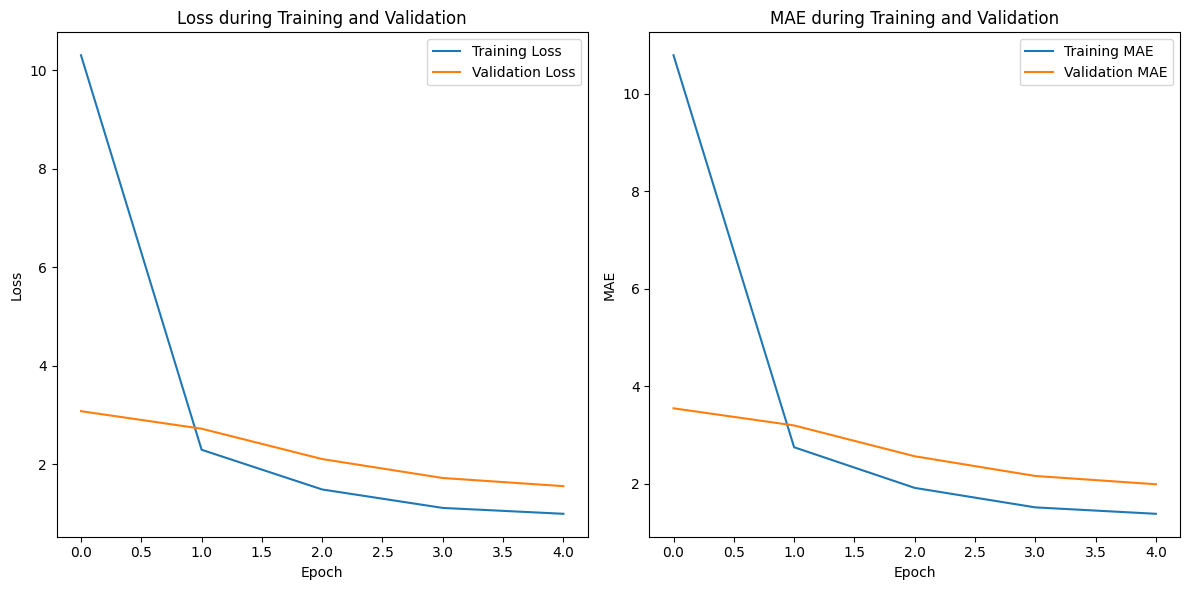

In [ ]:
# Membuat plot loss pada saat training dan validasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Membuat plot MAE pada saat training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()